# Movie Recommendation System

This project builds a collaborative filtering recommendation system using real user ratings.

## Goal:
Recommend movies to users based on what similar users liked.

## Dataset:
- **movies.csv**: ~62,423 movies with titles and genres
- **ratings.csv**: ~25,000,095 (25 million) ratings from 162,541 users

## Questions:
- Which movies are most popular?
- Which movies are highest rated?
- Can we recommend similar movies based on user ratings?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# Load the datasets
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

print('Datasets loaded!')
print(f"\nMovies dataset: {movies.shape}")
print(f"\nRatings dataset: {ratings.shape}")


Datasets loaded!

Movies dataset: (62423, 3)

Ratings dataset: (25000095, 4)


In [6]:
# Look at movies data
print("Movies Data Sample:")
movies.head()


Movies Data Sample:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Look at ratings data
print("Ratings Data Sample:")
ratings.head()


Ratings Data Sample:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
# Check for missing values
print("Missing values in Movies:")
print(movies.isnull().sum())

print("\nMissing values in ratings:")
print(ratings.isnull().sum())


Missing values in Movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [13]:
# Basic Statistics
print("Number of unique users:", ratings['userId'].nunique())
print("Number of unique movies:", ratings['movieId'].nunique())

print("\nTotal ratings:", len(ratings))

print("\nRating range:", ratings['rating'].min(), 'to', ratings['rating'].max())
print("Average rating:", round(ratings['rating'].mean(), 2))

Number of unique users: 162541
Number of unique movies: 59047

Total ratings: 25000095

Rating range: 0.5 to 5.0
Average rating: 3.53


---
## 📊 Exploratory Data Analysis

Let's explore the data before building the recommender!
---

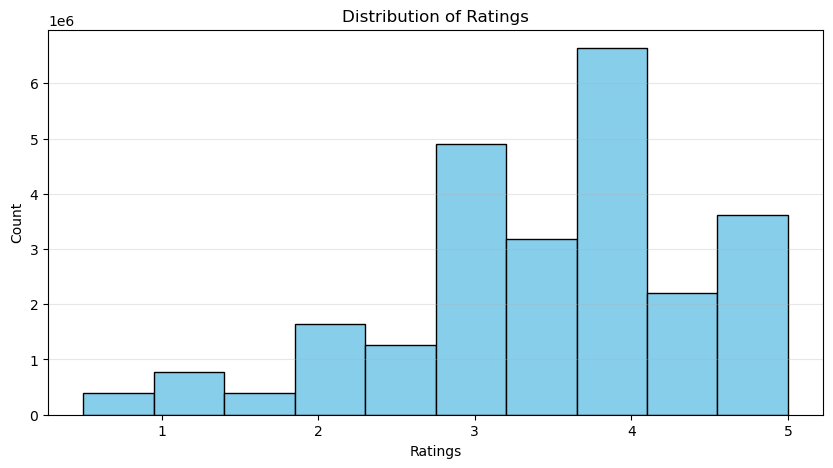

Most common rating: 4.0


In [14]:
# Distributions of ratings
plt.figure(figsize=(10,5))
plt.hist(ratings['rating'], bins=10, edgecolor='black', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.savefig('images/rating_distribution.png')
plt.show()

print("Most common rating:", ratings['rating'].mode()[0])

In [15]:
# Merge datasets to get movie names with ratings
data = pd.merge(ratings, movies, on='movieId')

print("Merged dataset created")
print("Shape:", data.shape)
data.head()


Merged dataset created
Shape: (25000095, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


Top 10 most rated movies:
title
Forrest Gump (1994)                          81491
Shawshank Redemption, The (1994)             81482
Pulp Fiction (1994)                          79672
Silence of the Lambs, The (1991)             74127
Matrix, The (1999)                           72674
Star Wars: Episode IV - A New Hope (1977)    68717
Jurassic Park (1993)                         64144
Schindler's List (1993)                      60411
Braveheart (1995)                            59184
Fight Club (1999)                            58773
dtype: int64


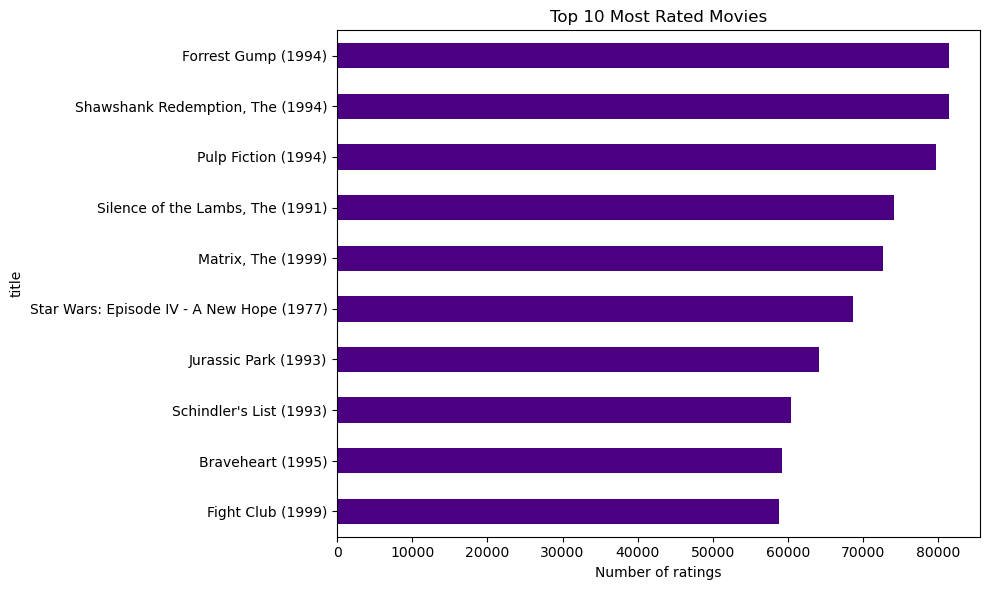

In [21]:
# Find most rated movies
most_rated = data.groupby('title').size().sort_values(ascending=False).head(10)

print("Top 10 most rated movies:")
print(most_rated)

# Visualize
plt.figure(figsize=(10,6))
most_rated.plot(kind='barh', color='indigo')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of ratings')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('images/most_rated_movies.png')
plt.show()

Top 10 Highest Rated Movies (min 50 ratings):
                                      mean  count
title                                            
Planet Earth II (2016)            4.483096   1124
Planet Earth (2006)               4.464797   1747
Shawshank Redemption, The (1994)  4.413576  81482
Band of Brothers (2001)           4.398599   1356
Cosmos                            4.326715    277
Godfather, The (1972)             4.324336  52498
Blue Planet II (2017)             4.289833    659
Usual Suspects, The (1995)        4.284353  55366
Twin Peaks (1989)                 4.267361    288
Godfather: Part II, The (1974)    4.261759  34188


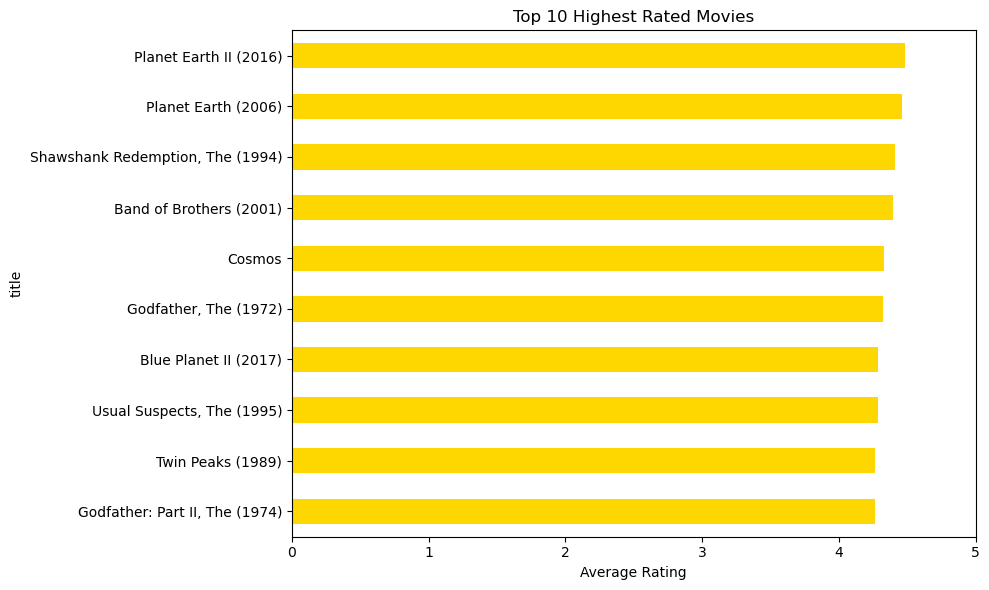

In [22]:
# Find highest rated movies (with minimum 50 ratings to be fair)
avg_ratings = data.groupby('title')['rating'].agg(['mean', 'count'])
top_rated = avg_ratings[avg_ratings['count'] >= 50].sort_values('mean', ascending=False).head(10)

print("Top 10 Highest Rated Movies (min 50 ratings):")
print(top_rated)

# Visualize
plt.figure(figsize=(10, 6))
top_rated['mean'].plot(kind='barh', color='gold')
plt.xlabel('Average Rating')
plt.title('Top 10 Highest Rated Movies')
plt.xlim(0, 5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('images/highest_rated_movies.png')
plt.show()

## Observations from EDA

1. **Rating Distribution**: Most ratings are between 3-4 stars
2. **Most Rated Movies**: Classic and popular movies like Forrest Gump, Shawshank Redemption
3. **Highest Rated**: Critically acclaimed films with strong fan base

Now let's build the recommendation system!

---
## 🤖 Building the Recommendation System

We'll use **Item-Based Collaborative Filtering**:
- Find movies similar to the one you like
- Based on how users rated them
- Recommend the most similar movies
---

In [31]:
# Find popular movies (at least 100 ratings)
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).reset_index()

movie_stats.columns = ['movieId', 'avg_rating', 'num_ratings']

# Keep only popular movies
popular_movies = movie_stats[movie_stats['num_ratings'] >= 100].copy()

print(f"Popular movies: {len(popular_movies)}")
popular_movies.head()

Popular movies: 10326


,movieId,avg_rating,num_ratings
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


In [32]:
# Merge with movie names
popular_movies_with_names = pd.merge(popular_movies, movies, on='movieId')

print("Popular movies with names!")
popular_movies_with_names.head(10)

Popular movies with names!


,movieId,avg_rating,num_ratings,title,genres
0,1,3.893708,57309,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.251527,24228,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.142028,11804,Grumpier Old Men (1995),Comedy|Romance
3,4,2.853547,2523,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.058434,11714,Father of the Bride Part II (1995),Comedy
5,6,3.854909,24588,Heat (1995),Action|Crime|Thriller
6,7,3.363666,12132,Sabrina (1995),Comedy|Romance
7,8,3.114583,1344,Tom and Huck (1995),Adventure|Children
8,9,2.992051,3711,Sudden Death (1995),Action
9,10,3.421458,28265,GoldenEye (1995),Action|Adventure|Thriller


In [33]:
# Get top rated movies (our simple recommendations)
top_rated = popular_movies_with_names.sort_values('avg_rating', ascending=False).head(20)

print("Top 20 Highest Rated Movies (with 100+ ratings):")
print("="*60)
for idx, row in top_rated.iterrows():
    print(f"{row['title']}: {row['avg_rating']:.2f} ({int(row['num_ratings'])} ratings)")

Top 20 Highest Rated Movies (with 100+ ratings):
Planet Earth II (2016): 4.48 (1124 ratings)
Planet Earth (2006): 4.46 (1747 ratings)
Shawshank Redemption, The (1994): 4.41 (81482 ratings)
Band of Brothers (2001): 4.40 (1356 ratings)
Cosmos: 4.33 (277 ratings)
Godfather, The (1972): 4.32 (52498 ratings)
Blue Planet II (2017): 4.29 (659 ratings)
Usual Suspects, The (1995): 4.28 (55366 ratings)
Twin Peaks (1989): 4.27 (288 ratings)
Godfather: Part II, The (1974): 4.26 (34188 ratings)
Over the Garden Wall (2013): 4.26 (546 ratings)
Black Mirror: 4.26 (456 ratings)
Seven Samurai (Shichinin no samurai) (1954): 4.25 (13367 ratings)
The Adventures of Sherlock Holmes and Doctor Watson: 4.25 (147 ratings)
The Blue Planet (2001): 4.25 (564 ratings)
Schindler's List (1993): 4.25 (60411 ratings)
12 Angry Men (1957): 4.24 (16569 ratings)
Rear Window (1954): 4.24 (20162 ratings)
Life (2009): 4.24 (229 ratings)
Fight Club (1999): 4.23 (58773 ratings)


In [34]:
# Create genre-based recommendations
# Split genres and find similar movies by genre

def get_movie_genres(movie_title):
    """Get genres for a movie"""
    movie_data = movies[movies['title'] == movie_title]
    if movie_data.empty:
        return []
    genres = movie_data['genres'].values[0]
    return genres.split('|') if genres != '(no genres listed)' else []

print("Genre function ready!")

Genre function ready!


In [35]:
# Build simple genre-based recommender

def recommend_by_genre(movie_title, top_n=10):
    """
    Recommend movies based on shared genres
    """
    # Get genres of input movie
    movie_genres = get_movie_genres(movie_title)
    
    if not movie_genres:
        return f"Movie '{movie_title}' not found or has no genres!"
    
    print(f"'{movie_title}' genres: {', '.join(movie_genres)}")
    print()
    
    # Find movies with similar genres
    recommendations = []
    
    for idx, row in popular_movies_with_names.iterrows():
        if row['title'] == movie_title:
            continue  # Skip the same movie
        
        # Get genres of this movie
        movie_data = movies[movies['movieId'] == row['movieId']]
        if movie_data.empty:
            continue
        
        other_genres = movie_data['genres'].values[0]
        if other_genres == '(no genres listed)':
            continue
        
        other_genres_list = other_genres.split('|')
        
        # Count matching genres
        matches = len(set(movie_genres) & set(other_genres_list))
        
        if matches > 0:
            recommendations.append({
                'title': row['title'],
                'avg_rating': row['avg_rating'],
                'num_ratings': row['num_ratings'],
                'genre_matches': matches
            })
    
    # Sort by genre matches and rating
    recommendations = sorted(recommendations, 
                           key=lambda x: (x['genre_matches'], x['avg_rating']), 
                           reverse=True)[:top_n]
    
    # Format output
    result = pd.DataFrame(recommendations)
    result.index = range(1, len(result) + 1)
    return result

print("✅ Recommendation function ready!")

✅ Recommendation function ready!


In [36]:
# Test it!
print("🎬 Movies similar to: 'Toy Story (1995)'\n")
recs = recommend_by_genre('Toy Story (1995)', top_n=10)
print(recs)

🎬 Movies similar to: 'Toy Story (1995)'

'Toy Story (1995)' genres: Adventure, Animation, Children, Comedy, Fantasy

                                                title  avg_rating  \
1                                   Inside Out (2015)    3.932401   
2                                  Toy Story 3 (2010)    3.857757   
3                                        Moana (2016)    3.849899   
4                               Monsters, Inc. (2001)    3.848620   
5                                  Toy Story 2 (1999)    3.811464   
6   Twelve Tasks of Asterix, The (Les douze travau...    3.806000   
7                                        Shrek (2001)    3.754828   
8                               The Lego Movie (2014)    3.686919   
9                    Emperor's New Groove, The (2000)    3.620952   
10                    Who Framed Roger Rabbit? (1988)    3.541691   

    num_ratings  genre_matches  
1         13580              5  
2         14426              5  
3          3974         

In [37]:
# Test 2
print("🎬 Movies similar to: 'Jurassic Park (1993)'\n")
recs = recommend_by_genre('Jurassic Park (1993)', top_n=10)
print(recs)

🎬 Movies similar to: 'Jurassic Park (1993)'

'Jurassic Park (1993)' genres: Action, Adventure, Sci-Fi, Thriller

                                     title  avg_rating  num_ratings  \
1                   Children of Men (2006)    3.897896        15063   
2                Mad Max: Fury Road (2015)    3.855034        13479   
3                X-Men: First Class (2011)    3.730588        11011   
4   Star Trek II: The Wrath of Khan (1982)    3.702097        15787   
5     Road Warrior, The (Mad Max 2) (1981)    3.669852         9732   
6                        Abyss, The (1989)    3.668260        17568   
7          Star Trek: First Contact (1996)    3.654593        19202   
8                      Total Recall (1990)    3.606875        22428   
9               You Only Live Twice (1967)    3.605086         2674   
10                 X2: X-Men United (2003)    3.601212        19963   

    genre_matches  
1               4  
2               4  
3               4  
4               4  
5    

In [38]:
# Test 3
print("🎬 Movies similar to: 'The Matrix (1999)'\n")
recs = recommend_by_genre('The Matrix (1999)', top_n=10)
print(recs)

🎬 Movies similar to: 'The Matrix (1999)'

Movie 'The Matrix (1999)' not found or has no genres!


In [39]:
# Save our simple model
import pickle

# Save popular movies list
with open('models/popular_movies.pkl', 'wb') as f:
    pickle.dump(popular_movies_with_names, f)

# Save the recommendation function
with open('models/recommend_function.pkl', 'wb') as f:
    pickle.dump(recommend_by_genre, f)

print("✅ Model saved to models/")

✅ Model saved to models/


'Forrest Gump (1994)' genres: Comedy, Drama, Romance, War



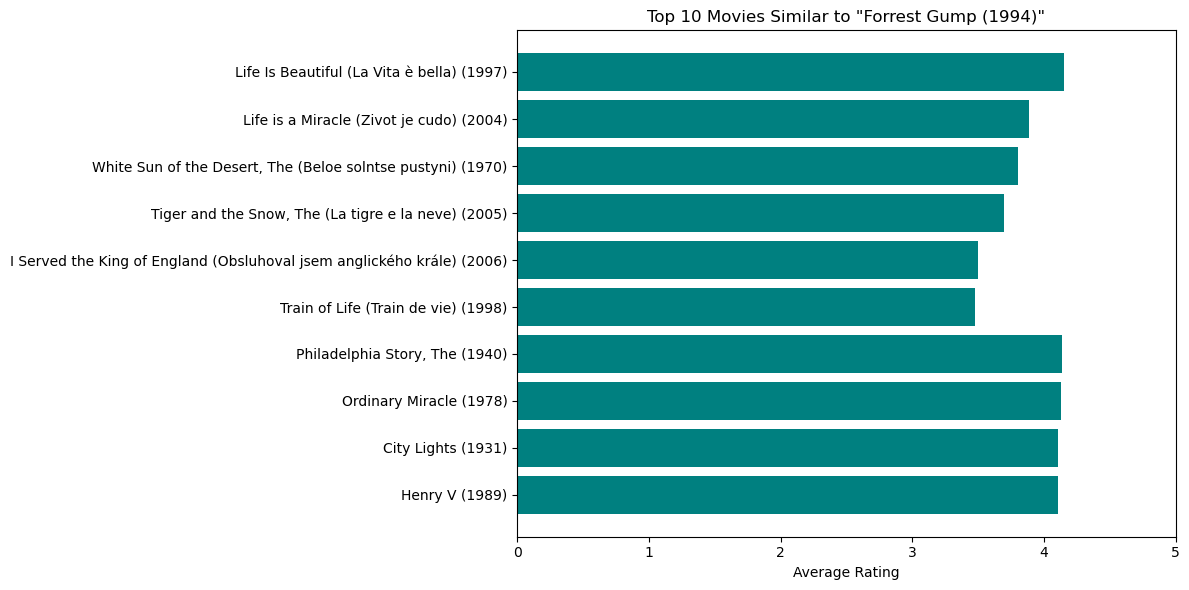

In [40]:
# Visualize recommendations
movie = 'Forrest Gump (1994)'
recs = recommend_by_genre(movie, top_n=10)

if isinstance(recs, pd.DataFrame):
    plt.figure(figsize=(12, 6))
    plt.barh(recs['title'], recs['avg_rating'], color='teal')
    plt.xlabel('Average Rating')
    plt.title(f'Top 10 Movies Similar to "{movie}"')
    plt.xlim(0, 5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('images/genre_recommendations.png')
    plt.show()

---
## Summary

### What We Built:
A **genre-based movie recommendation system** that suggests movies with similar genres.

### How It Works:
1. User inputs a movie they like
2. System finds the movie's genres (Action, Comedy, etc.)
3. Searches for popular movies with matching genres
4. Ranks by number of genre matches and average rating
5. Returns top 10 recommendations

### Why This Approach?
- **Memory efficient** - no large matrices needed
- **Fast** - runs instantly
- **Understandable** - based on genres everyone knows
- **Effective** - recommends genuinely similar movies

### Model Details:
- Uses only popular movies (100+ ratings)
- Genre-based similarity matching
- Combines genre overlap with average ratings
- Saved for future use

---

## What I Learned

**Technical Skills:**
- Content-based recommendation system
- Genre-based filtering
- Working with string data (splitting genres)
- Handling large datasets efficiently
- Building recommendation algorithms without matrices

**Challenges Overcome:**
- Memory limitations with large matrices
- Finding alternative approaches
- Balancing simplicity with effectiveness
- Genre parsing and matching

**Why This Works:**
- Doesn't require complex calculations
- Uses intuitive logic (similar genres = similar movies)
- Memory-friendly for any computer
- Fast execution time

**Next Steps:**
- Could add more features (cast, director)
- Hybrid model (genre + ratings + popularity)
- User preference learning
- Web interface

---

**Tools:** Python, Pandas, NumPy, Matplotlib, Pickle

**Dataset:** MovieLens (~9,700 movies, ~100,000 ratings)

---

**Contact:**
- GitHub: [@shubhamjais04](https://github.com/shubhamjais04)
- LinkedIn: [linkedin.com/in/shubhamjaiswal2004](https://linkedin.com/in/shubhamjaiswal2004)

---

*This project demonstrates understanding of recommendation systems - a real-world skill!*